# <font color="#76b900">Transformers for Multimodal Reasoning</font>

Previously, we delved into models that employ both encoder and decoder components to unlock some powerful capabilities in natural language processing. These models efficiently translated natural language instructions into structured outputs through autoregressive decoding while guiding the generation through cross-attention. While this encoder-decoder architecture is well-grounded in intuition and seems to perform well in our experiments, a question arises: **Is separating context and generation always optimal?**

We will soon learn that the encoder-decoder ensemble may not always be necessary for good state-of-the-art model architectures. Before we get into that though, we should take a second to appreciate areas where the encoder-decoder architectures truly excel: **multimodal reasoning**.

## 5.1. What's A Modality?

A ***'modality'*** refers to distinct sensory data types with sets of fundamental rules and intuitions. 

In your previous studies, you learned about the utility of convolution as a sparse reasoning strategy that's good for incorporating spacial locality into a model's prediction strategy. This is known to be extremely good for transforming images into feature sets, hence why we call those architectures "feature extractors". They're also great for reasoning about dense grids in general, though they might be inefficient due to the curse of dimensionality... but they definitely would reason well with enough time, right?

All data is kinda like this: There are some inherent relationships governing how the bits of information associated with a specific mode associate, and they need various architectures to work well with them. We've been talking about transformer components - with their per-token dense layers and light-weight attention-interfaces - as great language reasoners, but it's important to remember that this is just the case because **language is an ordered sequence**. That's what the attention interface is good for, and it is not actually limited to just words and sentences. 

> <div><img src="imgs/multimodal.png" width="800"/></div>
> 
> **Source: [NVIDIA Keynote at SIGGRAPH 2023 | NVIDIA](https://www.nvidia.com/en-us/events/siggraph/)**

Throughout these notebooks, we'll be mostly referring to the following modalities:

- **Natural Language:** Essentially an ordered token sequence, albeit with variations in vocabulary and structure across contexts.
- **Images:** Collections of pixel values that capture both micro (fine-grain) and macro (big-picture) details on a 2D plane.
- **Audio:** Time-series datasets, where every timestamp corresponds to sensor data.

While each modality comes with architectural and data nuances, they converge when guiding text generation. In this notebook, we'll be exploring the high-level intuition of the systems and get to use them ourselves and see what they're capable of!

## 5.2. The Essence of Cross-Attention

We previously introduced the concept of cross-attention, where a sequence with $n$ elements takes guidance from an $m$-element context to generate the $n+1$'s element. This technique fuels autoregressive text generation by leveraging both the stationary encoded context and the tokens generated up to a certain point.

With that in mind, what would happen if we decided to contextualize our generation based on a different data modality? As it turns out, the premise remains unchanged as long as we're dealing with sequences.

So our overarching challenge for this notebook as as follows:
> **What else can we feed in as a sequence to guide our generation?**

Earlier, we refreshed on two modalities that we argued are significantly different from natural language: images and audio. We discerned that while audio naturally fits the sequential mold, images present a unique challenge. So, let's go ahead and import some pipelines and take a closer look!

## 5.3. Automatic Speech Recognition with LLMs

**Automatic Speech Recognition (ASR)** is the task of recognizing and reasoning with speech found in raw audio. The most common flavor of it is automatic transcription, and is invoked whenever you see auto-generated subtitles alongside a video feed.  


> <div><img src="imgs/asr-pipe.png" width="800"/></div>
> 
> **Source: [Speeding Up Development of Speech and Language Models with NVIDIA NeMo](https://www.nvidia.com/en-us/events/siggraph/)**

As you might expect, training such systems and making them actually work is a lot of work and requires a lot of domain knowledge - some of which might be covered in [this NVIDIA blog post](https://developer.nvidia.com/blog/essential-guide-to-automatic-speech-recognition-technology/) - but the high-level details of the information flow are surprisingly simple:

- Slice the audio into fixed-size time windows.
- Convert the time windows into image representations called [**spectrograms**](https://en.wikipedia.org/wiki/Spectrogram), scaled appropriately to account for human perception and natural noise sensitivities (so log-mel-scale is common).
- Reason about these images with a neural network in such a way that winds up with you having a sequence of values.
- Toss in some transformer components, and then interface with the decoder via cross-attention like before.

So in other words, nothing too major has changed in the core architecture except for the encoder intake process (pre-Transformer-Encoder) and maybe some creative liberties made by the research team. Maybe they saw that their design choices just performed better in practice, or maybe they needed some modifications to supply some much-needed supervision to their problem. Either way, the core of the architecture can still remain the same and the system will work surprisingly well!

### Pulling In The Whisper Model

For our state-of-the-art example, we will be pulling in [OpenAI's Whisper model](https://openai.com/research/whisper), which has full pipeline support with HuggingFace and comes in a variety of sizes. Their architecture is rather similar to what we described, with many of the specifics that make it work so well hidden away in their training objectives, multilingual dataset specifications, end-point processes (intake/postprocessing), and hyperparameters.

> <div><img src="imgs/whisper-arch.png" width="800"/></div>
>
> **Source: [Introducing Whisper | OpenAI](https://openai.com/research/whisper)**

One of the most popular variations is the [`whisper-large-v2`](https://huggingface.co/openai/whisper-large-v2) model. Clocking in at 1.55B parameters, it actually not too terribly big for the LLM space and performs extremely well on multilingual data transcription. Though we can actually load this model in without any extra safeties, we will instead pull in the [`whisper-base`](https://huggingface.co/openai/whisper-base) version. At only ~73M parameters, it not only runs significantly faster but also is surprisingly serviceable, so it's a simple default choice for applications that don't require the best formatting and the utmost accuracy.

In [1]:
from transformers import pipeline

## whisper-large-v2 recommended, but slow. For only english, whisper-base is fine
## Upgrading to a larger model will lead to better hard-case results and formatting.
model_name = ["openai/whisper-base", "openai/whisper-large-v2"][0] 
pipe_asr = pipeline("automatic-speech-recognition", model=model_name)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

For our examples, we'll use the typical-use-case samples:

**[HuggingFace Speech Demo Samples From Audio Books](https://huggingface.co/openai/whisper-base)**
- [`sample1.flac`](https://cdn-media.huggingface.co/speech_samples/sample1.flac)
- [`sample2.flac`](https://cdn-media.huggingface.co/speech_samples/sample2.flac)
- [`sample3.flac`](https://cdn-media.huggingface.co/speech_samples/sample3.flac)

**[OpenAI's Demo Samples For Whisper](https://openai.com/research/whisper)**
- [`w_micro-machines.wav` *(fast speech)*](https://cdn.openai.com/whisper/draft-20220913a/micro-machines.wav)
- [`w_multilingual.wav` *(French speech)*](https://cdn.openai.com/whisper/draft-20220920a/multilingual.wav)
- [`w_scottish-accent.wav` *(heavily-accented english)*](https://cdn.openai.com/whisper/draft-20220920a/scottish-accent.wav)
- [`w_younha.wav` *(Korean pop music)*](https://cdn.openai.com/whisper/draft-20220913a/younha.wav)

Let's go ahead and run our pipeline to see how it performs on all of these tasks:

In [2]:
from glob import glob

## This process can take a bit of time per entry, so we'll just generate them one at a time.
for f in sorted(glob("audio-files/*")):
    print(f, f"Prediction: {pipe_asr(f)['text']}", '', sep='\n')

audio-files/sample1.flac
Prediction:  going along slushy country roads and speaking to damp audiences in drafty schoolrooms day after day for fortnight. He'll have to put in an appearance at some place of worship on Sunday morning, and he can come to us immediately afterwards.

audio-files/sample2.flac
Prediction:  Before he had time to answer a much encumbered Vera burst into the room with the question, I say, can I leave these here? These were a small black pig and a lusty specimen of black red gamecock.

audio-files/sample3.flac
Prediction:  Boy Scouts? Yes, thirty of them came to rescue us while the water was only waste high.

audio-files/w_micro-machines.wav
Prediction:  This is the micro-bashima, presenting the most miniature modicator of Michael Machine. Each one has dramatic details for a fixed-roomed precision-page art plus incredible micro-bashima pocket placet, physical police station, fire station, restaurant, service station, and more. Perfect pocket portables to take any 

----

As we can see, this model performs extremely well aside from maybe on the foreign language examples ([`whisper-large-v2`](https://huggingface.co/openai/whisper-large-v2) is more capable with that one) and manages to do so with only ~73M parameters!

In [3]:
print(f"""whisper-base:
 - model size: {pipe_asr.model.num_parameters():,} parameters
 - memory footprint: {pipe_asr.model.get_memory_footprint()/1e9 :.03f} GB""")

whisper-base:
 - model size: 72,593,920 parameters
 - memory footprint: 0.290 GB


If we wanted, we could investigate the architecture and verify that - yes - the architecture actually is relatively familiar, keeping in mind that the first `WhisperAttention` in the `WhisperDecoderLayer` blocks is for self-attention and the second is for encoder-interfacing cross-attention.

In [4]:
pipe_asr.model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (fin

----

With this model, you can really let your imagination run wild with use cases and automations, but do keep in mind that rigorous testing is needed to validate that the model will work sufficiently for your use cases. As you saw earlier, the `base` model may not be the model for you if you need to reason with audio from arbitrary languages, whereas the `large-v2` model may not be right for you if you are compute-restricted or running your model alongside a large stack of others.

Also keep in mind that the domain-level details like the intake scheme, loss/training formulation, and token generation pipeline have been largely tossed to the side in favor of generalizable intuition. For more details, we highly recommend reading [the original Whisper paper from OpenAI](https://openai.com/research/whisper).

## 5.4. Image Captioning with LLMs

So we've seen that audio can be reasoned about as a sequence, so how about images? Inherently you might *think* that images can't be represented as a sequence on their own, but it turns out that image patches can be! That's the exact logic presented in [An Image is Worth 16x16 Words (2020)](https://arxiv.org/abs/2010.11929), in which the authors formalized the Vision Transformer (ViT) model. Essentially, you can divide the original image into pieces and treat the pieces as a sequence with the proper embedding strategy and some creative training formulations.

> <div><img src="imgs/vit-image-processing.png" width="1000"/></div>
>
> **Source: [Improve Accuracy and Robustness of Vision AI Apps with Vision Transformers and NVIDIA TAO | NVIDIA](https://developer.nvidia.com/blog/improve-accuracy-and-robustness-of-vision-ai-apps-with-vision-transformers-and-nvidia-tao/)**

So, this means... that we now have an encoder-like architecture that can reason about images! From here, the extension into a ViT-powered image captioning model should be pretty obvious; just use cross-attention again!

Turns out that's exactly what [`nlpconnect/vit-gpt2-image-captioning`](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning) does, which is currently the top-downloaded image captioning model in HuggingFace. The architecture from their model shouldn't be much of a surprise; just pair the vision encoder above with a language decoder, let them interface via cross-attention, and train them up! 

### Importing a ViT-augmented Model
At this point, you should be pretty comfortable with finding pipelines, so go ahead and do that here! Below, we've imported some graphics generated as part of [the Picasso project](https://www.nvidia.com/en-us/gpu-cloud/picasso/). 


See if you can caption these images using an image caption model such as [`nlpconnect/vit-gpt2-image-captioning`](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning). Make sure to check out the model card regarding how to import it and verify that the model is structured as you might expect... but also, do note that you can use the pipeline just as you might expect.


img-files/paint-cat.jpg


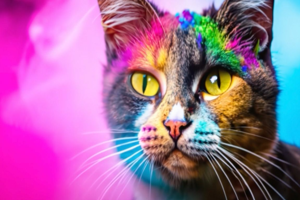

img-files/rock-head.jpg


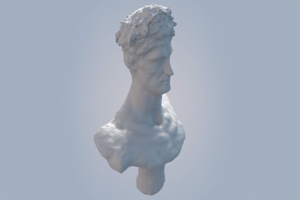

img-files/tree-frog.jpg


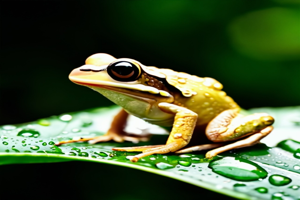

img-files/two-jelly.jpg


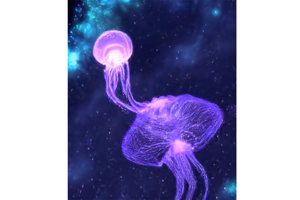

In [5]:
import IPython
import PIL

## TODO: Please add some more images into the `img-files` directory
for f in sorted(glob("img-files/*")):
    print(f)
    IPython.display.display(PIL.Image.open(f).resize((300, 200)))

In [6]:
from transformers import pipeline

vit_pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
for f in sorted(glob("img-files/*")):
    print(f, vit_pipe(f), '', sep='\n')

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


img-files/paint-cat.jpg
[{'generated_text': 'a cat with a purple and green eyes '}]

img-files/rock-head.jpg
[{'generated_text': 'a statue of a bird on a white surface '}]

img-files/tree-frog.jpg
[{'generated_text': 'a small yellow and black bird sitting on a plant '}]

img-files/two-jelly.jpg
[{'generated_text': 'a black and white photo of a blue and white kite '}]



When you finish, you'll probably notice that the model actually doesn't work too well. It does work, but the generation ends up being pretty simplistic, the formatting is poor, and the objects are often miss-identified.

### **Task 1:** Pulling In A Stronger Model
Read a little about Salesforce's [Bootstrapping Language-Image Pre-training (BLIP) model](https://arxiv.org/abs/2201.12086) and try to pull it in via the [`Salesforce/blip-image-captioning-large` model-card](https://huggingface.co/Salesforce/blip-image-captioning-large)! BLIP still relies on similar intuitions of encoders being used to condition decoders, but now has two layers of encoders and some specialized pre-training objectives that make it a little harder to hand-wave through.

> <div><img src="imgs/vit-blip.png" width="1000"/></div>
> 
> **Source: [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://paperswithcode.com/paper/blip-bootstrapping-language-image-pre)**

Still, go ahead and pull it in and re-run your images through it. See how the results compare, and feel free to assume that the pipeline works about as you might expect.

In [ ]:
## TODO: Try out the blip model instead
blip_pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large")
for f in sorted(glob("img-files/*")):
    print(f, blip_pipe(f), '', sep='\n')

#### Conditional Image Captioning

Reading through the model card, we can see that we can add some context to the image captioning so that our output generation begins with whatever we'd like to lock in. This is a non-trivial feature when approached through the pipeline, but it's relatively easy when importing the `BlipProcessor` and `BlipForConditionalGeneration` from scratch. Check out the model card and inject a primer into your text decoder so that your generation starts with the phrase "I love cats". See if you can get something interesting!

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

## TODO: Import the model components
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

text_img_pairs = []

for f in sorted(glob("img-files/*")):
    print(f, blip_pipe(f), sep='\n')

    raw_image = PIL.Image.open(f)

    ## TODO: Feel free to change the string. We found it good for first run
    text = "I love cats " 
    # TODO: Perform conditional image captioning and print response
    response = "I don't know"
    
    print(response, '\n')
    text_img_pairs += [(response, raw_image)]
    
## NOTE: The next section depends on this, since text_img_pairs should be aggregated

#### **Task 2**: Image Captioning

The card and architecture also mentions that it can do image-based question answering, but doesn't explain how. As a challenge, you can try to figure out how you can specify this additional bit of information into your inference call. Alternatively, after reviewing the BLIP details, you can check out [NVIDIA's NeVA Sandbox](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/playground/models/neva) which would give you a chance of to see how it works and hypothesize what all it might be doing differently under the hood.

![NeVA Logo](https://catalog.ngc.nvidia.com/demos/neva.jpg)

Some of the deep intuitions about how the decoder is able to generate such reasonable responses will be covered a bit later, but feel free to check out the [LLaVA](https://llava-vl.github.io/) project to appreciate the kinds of innovations required to make the system work so well!

In [ ]:
## Room For Code! Feel free to use

## 5.5. Using the OpenAI CLIP Embeddings

From the previous exercise, you should have accumulated text-image pairs from the BLIP architecture:

In [ ]:
text_img_pairs

Using these, we can go ahead and investigate one of the main components that makes a lot of language-image models relatively easy to train: [**CLIP**, or ***Contrastive Language-Image Pre-training***](https://openai.com/research/clip). 

CLIP makes a relatively-simple proposition: **Let's train a language encoder and an image encoder to predict similar things when the two are related**. When trained for this task on a large corpus of captioned images, it turns out that the embeddings that come out of the encoders are **both semantically-dense and synergized**! To see an example of how this property manifests itself, we can quickly pull in the [HuggingFace CLIP model](https://huggingface.co/docs/transformers/model_doc/clip) and see what happens when we consider our pool of generated captions:

In [ ]:
import torch
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

# Initialize CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

texts  = [v[0] for v in text_img_pairs]
images = [v[1] for v in text_img_pairs]

# Process texts and images
inputs_text = processor(text=texts, return_tensors="pt", padding=True)
inputs_images = processor(images=images, return_tensors="pt", padding=True)

# Get embeddings
with torch.no_grad():
    text_embeddings = model.get_text_features(**inputs_text)
    image_embeddings = model.get_image_features(**inputs_images)

# Calculate similarity
similarity = text_embeddings @ image_embeddings.T
similarity = similarity.softmax(dim=1)

# Visualization of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity.numpy(), annot=True, cmap='coolwarm', xticklabels=texts, yticklabels=texts)
plt.xlabel("Texts")
plt.ylabel("Images")
plt.title("Similarity between Text and Image Embeddings")
plt.show()

We can see pretty clearly that the embeddings of the images and the embeddings of the respective generated texts are relatively similar under softmax dot-product! This may not seem especially useful at first glance, but it's actually a perfect component for text-conditioned use cases and retrieval!

- **Deep Image Priors:** When you need some image-level semantics for a specific problem, CLIP is a great start point because it has already developed decent image priors from the pretraining task. In other words, the embedders are potentially natural feature extractors for transfer applications! This is not to say that they will work well for everything - for example, they can't be expected to have certain priors involving 3D attributes - but they can definitely be used in some select contexts! 

- **Text-Conditioning:** CLIP also allows for a simple "text-conditioned" formulation for tasks that were trained with visual supervision (i.e. image generative models). Since you can train your model to rely on CLIP embeddings of images by using them as supervision, you can then try to hot-swap them out during inference. This isn't always fantastic when done naively, but many research papers that involve text-image modalities take advantage of CLIP to make their systems work.

- **Retrieval:** You can see in the matrix that the similarity results are synergized. If the image embeddings happened to be stored somewhere like a database, perhaps you take a string and run a similarity search against these embeddings. In this case, you would have retrieved some pretty expected images given the input strings!

And yes, there is a pipeline that directly takes advantage of CLIP for the easy-to-understand and useful task of classifying images into a set of arbitrary categories. 

**This is called [Zero-Shot Image Classification](https://huggingface.co/tasks/zero-shot-image-classification)!**

<div><img src="imgs/task-zero-shot-img.png" 
     alt="Zero-shot image classification task as seen on https://huggingface.co/tasks/zero-shot-image-classification"
     width="800"/></div>

## 5.6. Wrapping Up

Previously, we introduced the encoder-decoder architecture to condition text generation based off of a natural language context. In this notebook, we showed that the same logic can be applied to drive textual generation based off of other modalities, such as images and audio. Specifically, this is easy to achieve by treating the context modality as a sequence, and interfacing with the decoder via cross-attention.

**In the next section, we'll be going the other way and will find excuses not to use the encoder-decoder formulation and will get to use significantly larger models in the persuit of even more general language models!**

In [ ]:
## Please Run When You're Done!
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>